# Reinforcement Learning

# Setup
First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -q -U tf-agents pyvirtualdisplay gym[box2d]
    %pip install -q -U atari_py==0.2.5

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from IPython import display
from base64 import b64decode

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/grap

# Reinforcement Learning

In Reinforcement Learning, a software agent makes observations and takes actions within an environment, and in return it receives rewards. Its objective is to learn to act in a way that will maximize its expected rewards over time.

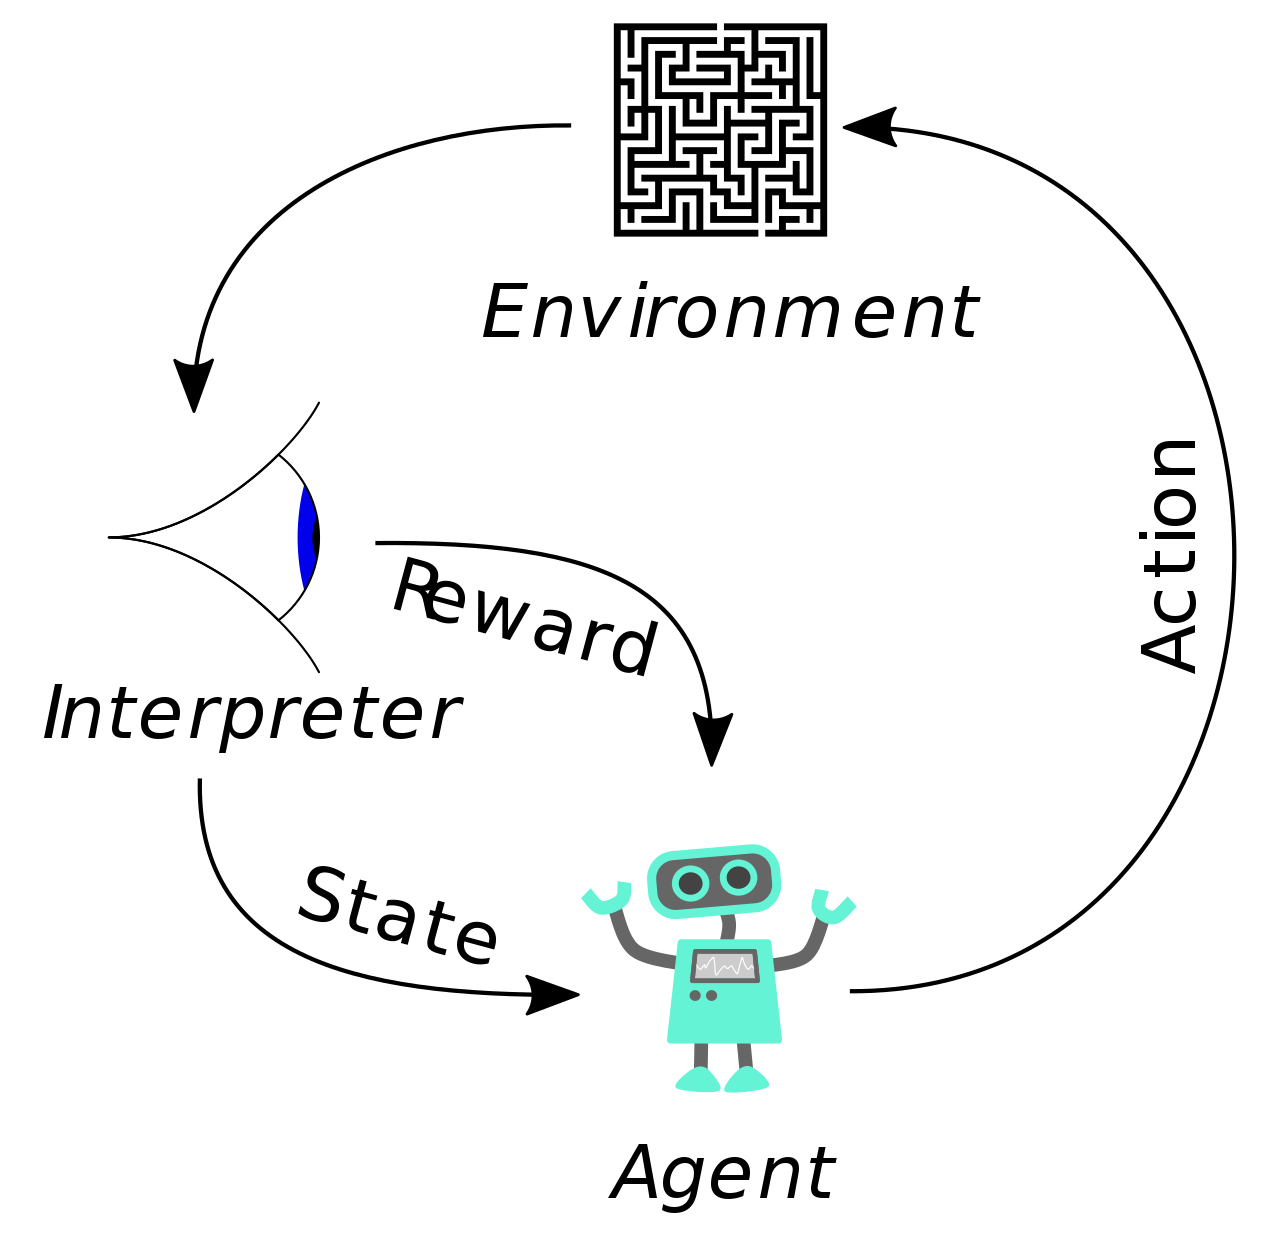

The typical framing of a Reinforcement Learning (RL) scenario: an agent takes actions in an environment, which is interpreted into a reward and a representation of the state, which are fed back into the agent. The algorithm a software agent uses to determine its actions is called its policy.

# Introduction to OpenAI gym

One of the challenges of Reinforcement Learning is that in order to train an agent, we first need to have a working environment. If you want to program a walking robot, then the environment is the real world, and you can
directly train your robot in that environment, but this has its limits: if the robot falls off a cliff, you can’t just click Undo. You can’t speed up time either; adding more computing power won’t make the robot move any faster. And it’s generally too expensive to train 1,000 robots in parallel. In short, training is hard and slow in the real world, so you generally need a simulated environment at least for bootstrap training.

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`:

In [1]:
import gym

Let's list all the available environments of the gym:

In [ ]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

# CartPole Environment

In this lab, we will use CartPole environment. The CartPole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

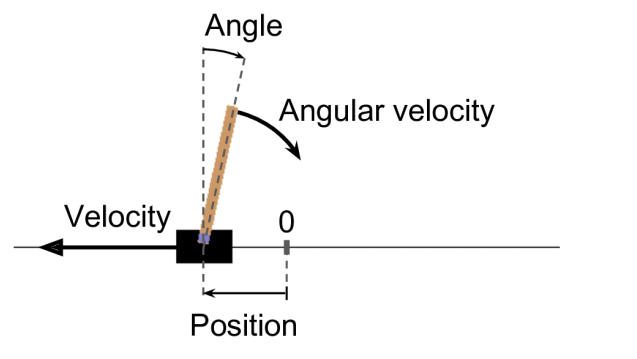

Lets create CartPole environment.

In [5]:
import gym
env=gym.make("CartPole-v1", render_mode="rgb_array")

Let's initialize the environment by calling is `reset()` method. This returns an observation:

In [ ]:
# env.seed(42)
obs = env.reset()

Observations vary depending on the environment. In CartPole case, it is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity (positive means right), the angle of the pole (0 = vertical), and the angular velocity (positive means clockwise).

In [5]:
obs

(array([0.02471034, 0.03801309, 0.03793126, 0.02317896], dtype=float32), {})

An environment can be visualized by calling its `render()` method, and you can pick the rendering mode (the rendering options depend on the environment). For that t owrok, we need to install following dependencies:

In [ ]:
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 70 not upgraded.
  Using cached PyVirtualDisplay-0.2.5-py2.py3-none-any.whl (13 kB)
  Attempting uninstall: pyvirtualdisplay
    Found existing installation: PyVirtualDisplay 2.2
    Uninstalling PyVirtualDisplay-2.2:
      Successfully uninstalled PyVirtualDisplay-2.2


In [ ]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [12]:
env.render()

In this example we will set `mode="rgb_array"` to get an image of the environment as a NumPy array:

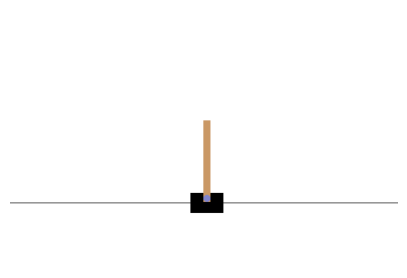

In [25]:
import matplotlib.pyplot as plt

def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [20]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left or towards the right.

Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [34]:
action = 1  # accelerate right
obs, reward, done, info,kk = env.step(action)
#the observations:
print(obs) # position, velocity, angle, angular velocity
print(obs[2])

[ 0.09740468  1.2179289  -0.08803162 -1.7780446 ]
-0.08803162


The step() method executes the given action and returns four values that we will explain below:

$\textbf{Observations}$

-0.0066637406

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

NameError: name 'save_fig' is not defined

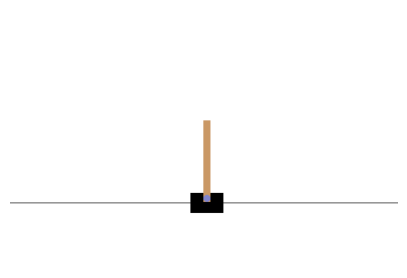

In [26]:
plot_environment(env)
save_fig("cart_pole_plot")

Looks like it's doing what we're telling it to do!

$\textbf{Reward}$

-- Amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward. The environment also tells the agent how much reward it got during the last step:

In [27]:
reward

1.0

$\textbf{Done}$

-- Whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. When the game is over, the environment returns `done=True`:

In [28]:
done

False

$\textbf{Info}$

-- Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [ ]:
info

{}

The sequence of steps between the moment the environment is reset until it is done is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True`), you should reset the environment before you continue to use it.

In [29]:
if done:
    obs = env.reset()

Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left and accelerates right when the pole is leaning toward the right. We will run this policy to see the average rewards it gets over 500 episodes:. Let's see if that works:

In [47]:
action = 1  # accelerate right
obs, reward, done, info,KK = env.step(action)
obs


array([-0.01839314,  0.15282708,  0.03622966, -0.32363686], dtype=float32)

In [56]:
 obs = env.reset()
 obs

(array([0.0473116 , 0.04295539, 0.03964878, 0.01024219], dtype=float32), {})

In [16]:


def basic_policy(obs):
    
    angle = obs[2]
    
    return 0 if angle < 0 else 1

totals = []
score=0
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()[0]
    #we want the first element of the tuple of env.rest which is the observation
    #the return from the rest is a tuple with two variables
    for step in range(200):#run the episode for 200 times if the episode is done before 200 then just break out of th einner for loop and go to th enext episode
        action = basic_policy(obs)
        obs, reward, done, _, info = env.step(action)
        score+=1
        #usually the env.step return four elements if the environmennt is normalized , however if the environment is not normalized then we will have 5 elements
        # env.render(mode="human")

        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)
    print("episode number is :",episode ,"/t", "episode reward:",episode_rewards)

#in the above code we are running the episode for 200 times and if the episode is done before 200 then we will break out of the inner for loop and go to the next episode
#the print statement is put in a place where after the inner for loop is terminated we print the episode number and it is total rewards for that particular episode
#the reward is 1 if the episode continues annd the done is false , if the episode terminates then the reward will be 0 

episode number is : 0 /t episode reward: 39.0
episode number is : 1 /t episode reward: 40.0
episode number is : 2 /t episode reward: 37.0
episode number is : 3 /t episode reward: 61.0
episode number is : 4 /t episode reward: 41.0
episode number is : 5 /t episode reward: 37.0
episode number is : 6 /t episode reward: 45.0
episode number is : 7 /t episode reward: 42.0
episode number is : 8 /t episode reward: 42.0
episode number is : 9 /t episode reward: 50.0
episode number is : 10 /t episode reward: 45.0
episode number is : 11 /t episode reward: 61.0
episode number is : 12 /t episode reward: 25.0
episode number is : 13 /t episode reward: 31.0
episode number is : 14 /t episode reward: 25.0
episode number is : 15 /t episode reward: 52.0
episode number is : 16 /t episode reward: 56.0
episode number is : 17 /t episode reward: 52.0
episode number is : 18 /t episode reward: 49.0
episode number is : 19 /t episode reward: 57.0
episode number is : 20 /t episode reward: 56.0
episode number is : 21 

In [23]:
print("the number of episodes that has reward  ",len(totals))
print(totals)
#totals is  the list of all rewards for each the episodes
#to know the number of elements of a list use the function len(listname)
import numpy as np
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

the number of episodes that has reward   500
[39.0, 40.0, 37.0, 61.0, 41.0, 37.0, 45.0, 42.0, 42.0, 50.0, 45.0, 61.0, 25.0, 31.0, 25.0, 52.0, 56.0, 52.0, 49.0, 57.0, 56.0, 40.0, 52.0, 42.0, 38.0, 25.0, 44.0, 35.0, 35.0, 42.0, 47.0, 40.0, 39.0, 47.0, 41.0, 38.0, 37.0, 39.0, 63.0, 35.0, 40.0, 48.0, 42.0, 40.0, 41.0, 39.0, 53.0, 34.0, 40.0, 53.0, 39.0, 35.0, 38.0, 61.0, 39.0, 27.0, 52.0, 39.0, 51.0, 31.0, 31.0, 51.0, 39.0, 39.0, 39.0, 32.0, 55.0, 25.0, 45.0, 31.0, 52.0, 41.0, 52.0, 50.0, 31.0, 36.0, 42.0, 46.0, 31.0, 30.0, 35.0, 54.0, 40.0, 49.0, 45.0, 44.0, 41.0, 36.0, 35.0, 31.0, 51.0, 38.0, 42.0, 42.0, 50.0, 25.0, 38.0, 37.0, 56.0, 58.0, 54.0, 25.0, 66.0, 37.0, 38.0, 45.0, 49.0, 35.0, 34.0, 34.0, 37.0, 25.0, 39.0, 51.0, 46.0, 53.0, 45.0, 39.0, 62.0, 35.0, 51.0, 53.0, 40.0, 41.0, 51.0, 40.0, 24.0, 42.0, 51.0, 35.0, 35.0, 52.0, 56.0, 34.0, 32.0, 51.0, 41.0, 52.0, 25.0, 40.0, 43.0, 36.0, 39.0, 42.0, 41.0, 39.0, 50.0, 43.0, 26.0, 34.0, 44.0, 53.0, 55.0, 31.0, 61.0, 49.0, 37.0, 51.0, 38.0, 

(42.522, 9.038003983181243, 24.0, 71.0)

Even with 500 tries, this policy never managed to keep the pole upright for more than 68 consecutive steps. Well, as expected, this strategy is a bit too basic. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode:

In [26]:
# env.seed(42)

frames = []

obs = env.reset()[0]
for step in range(200):
    img = env.render()
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, __,info = env.step(action)
    if done:
        break

TypeError: render() got an unexpected keyword argument 'mode'

Now show the animation:

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
plot_animation(frames)

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`. For example, if it outputs 0.7, then we will pick action 0 with 70% probability, or action 1 with 30% probability.

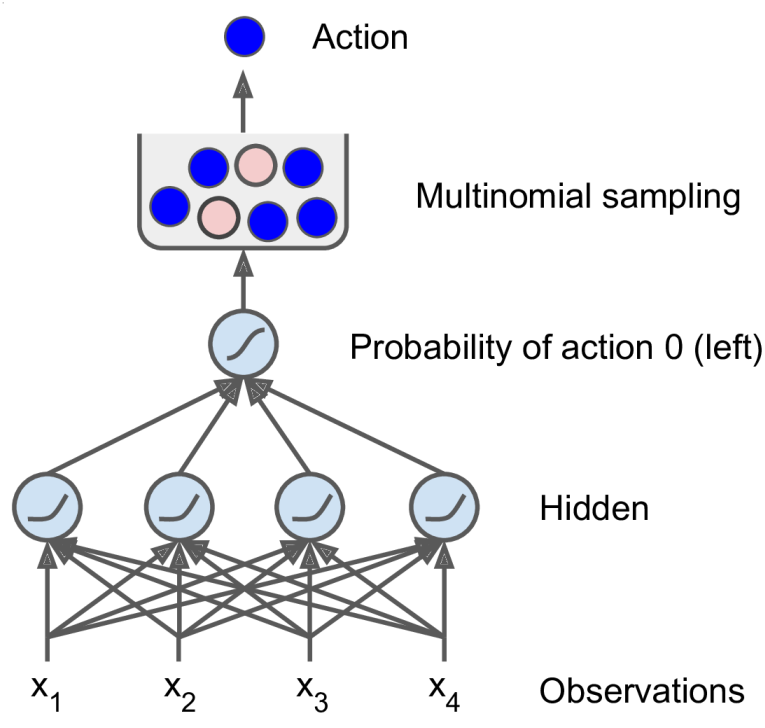

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Here is the code to build this neural network policy using tf.keras. We use a simple Sequential model to define the policy network. The number of inputs is the size of the observation space (which in the case of Cart‐
Pole is 4), and we have just five hidden units because it’s a simple problem. Finally, we want to output a single probability (the probability of going left), so we have a single output neuron using the sigmoid activation function.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

Let's write a small function that will run the model to play one episode, and return the frames so we can display an animation:

In [ ]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

Now let's look at how well this randomly initialized policy network performs:

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

We can make the same net play in 50 different environments in parallel (this will give us a diverse training
 at each step), and train for 5000 iterations. We also reset environments when they are done. We train the model using a custom training loop so we can easily use the predictions at each training step to advance the environments.

In [ ]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.094

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

Looks like it learned the policy better this time. Now let's see if it can learn a better policy on its own. One that does not wobble as much.

# Policy Gradients

To train this neural network we will need to define the target probabilities `y`. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple episodes, then making the actions in good episodes slightly more likely, while actions in bad episodes are made slightly less likely. First we play, then we go back and think about what we did.


Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients (we will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be):

In [ ]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

Let’s walk though this function:

-- Within the `GradientTape` block, we start by calling the model, giving it a single observation (we reshape the observation so it becomes a batch containing a single instance, as the model expects a batch). This outputs the probability of going left.

-- Next, we sample a random float between 0 and 1, and we check whether it is greater than `left_proba` . The action will be `False` with probability `left_proba`, or `True` with probability `1 - left_proba`. Once we cast this Boolean to a number, the action will be 0 (left) or 1 (right) with the appropriate probabilities.

-- Then we compute the loss using the given loss function, and we use the tape to compute the gradient of the loss with regard to the model’s trainable variables. Again, these gradients will be tweaked later, before we apply them, depending on how good or bad the action turned out to be.

-- Finally, we play the selected action, and we return the new observation, the reward, whether the episode is ended or not, and of course the gradients that we just computed.

If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`). And `False` means 0 when you cast it to a number, so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [ ]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

This code returns a list of reward lists (one reward list per episode, containing one reward per step), as well as a list of gradient lists (one gradient list per episode, each containing one tuple of gradients per step and each tuple containing one gradient tensor per trainable variable).

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [ ]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [ ]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [ ]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

Notice that the first episode was much worse than the second, so its normalized advantages are all negative; all actions from the first episode would be considered bad, and conversely all actions from the second episode would be considered good.

We are almost ready to run the algorithm! Now let’s define the hyperparameters. We will run 150 training iterations, playing 10 episodes per iteration, and each episode will last at most 200 steps. We will use a discount factor of 0.95:

In [ ]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

We also need an optimizer and the loss function. A regular Adam optimizer with learning rate 0.01 will do just fine, and we will use the binary cross-entropy loss function because we are training a binary classifier (there are two possible actions: left or right):

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

We are now ready to build and run the training loop!

In [ ]:
env = gym.make("CartPole-v1")
env.seed(42);

n_iterations = 100

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 99, mean rewards: 158.0

Let’s walk through this code:

-- At each training iteration, this loop calls the `play_multiple_episodes()` function, which plays the game 10 times and returns all the rewards and gradients for every episode and step.

-- Then we call the `discount_and_normalize_rewards()` to compute each action’s normalized advantage (which in the code we call the final_reward). This provides a measure of how good or bad each action actually was, in hindsight.

-- Next, we go through each trainable variable, and for each of them we compute the weighted mean of the gradients for that variable over all episodes and all steps, weighted by the `final_reward`.

-- Finally, we apply these mean gradients using the optimizer: the model’s trainable variables will be tweaked, and hopefully the policy will be a bit better.

And we’re done! The above code successfully learn to balance the pole on the cart as can be seen via following animation

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

# Markov Decision Process and Q-Value Iteration

We will briefly highlights Markov Chains.

-- In the early 20th century, the mathematician Andrey Markov studied stochastic processes with no memory, called Markov chains. Such a process has a fixed number of states ($s_0, s_1$ and $s_2$ as shown in figure below), and it randomly evolves from one state to another at each step. The probability for it to evolve from a state s to a state s′ is fixed, and it depends only on the pair (s, s′), not on past states.

-- They resemble Markov chains but with a twist: at each step, an agent can choose one of several possible actions, and the transition probabilities depend on the chosen action. Moreover, some state transitions return some reward (positive or negative), and the agent’s goal is to find a policy that will maximize reward over time. For example, the MDP represented in figure below has three states (represented by circles) and up to three possible discrete actions at each step (represented by diamonds as $a_0, a_1, a_2$).

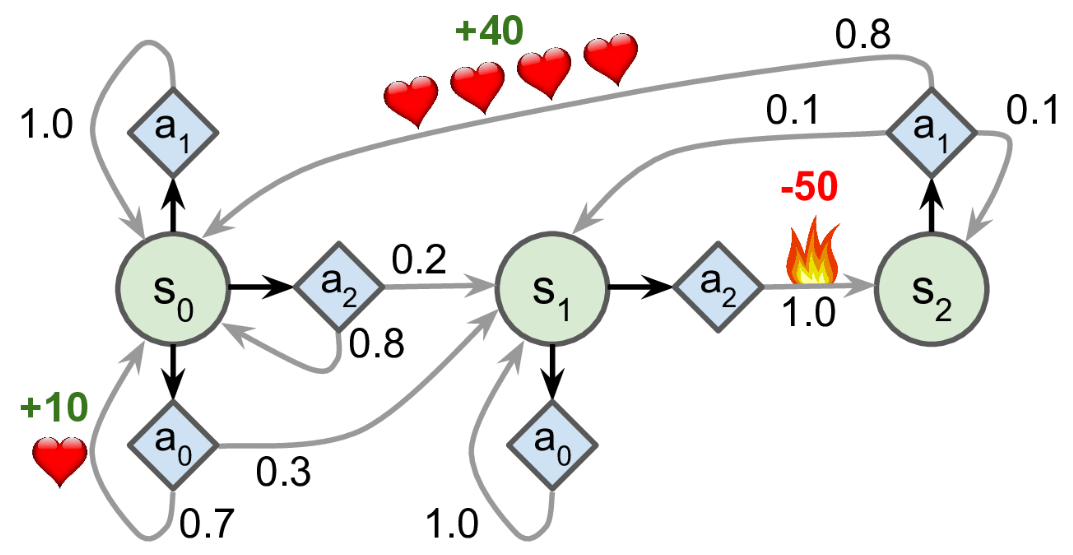

Can you guess which strategy will gain the most reward over time? It is difficult

Knowing the optimal state values can be useful, in particular to evaluate a policy, but it does not give us the optimal policy for the agent. Luckily, Bellman found a very similar algorithm to estimate the optimal state-action values, generally called $\textbf{Q-Values (Quality Values)}$. The optimal Q-Value of the state-action pair (s, a), noted Q*(s, a), is the sum of discounted future rewards the agent can expect on average after it reaches the state s and chooses action a, but before it sees the outcome of this action, assuming it acts optimally after that action.

Let’s apply Q-value algorithm to the MDP represented in figure above. First, we need to define the MDP with some transition probabilities, rewards and possible actions according to figure above. For example, in state $s_0$, if action $a_0$ is chosen then with proba 0.7 we will go to state $s_0$ with reward +10, with probability 0.3 we will go to state $s_1$ with no reward, and with never go to state $s_2$ (so the transition probabilities are `[0.7, 0.3, 0.0]`, and the rewards are `[+10, 0, 0]`):

In [ ]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

For example, to know the transition probability from $s_2$ to $s_0$ after playing action a 1 , we will look up `transition_probabilities[2][1][0]` (which is 0.8). Similarly, to get the corresponding reward, we will look up `rewards[2][1][0]` (which is +40). WE will apply iterative Q-value algorithm as discussed in class.

In [ ]:
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

gamma = 0.90  # the discount factor as discussed in class

history1 = [] # Not shown in the book (for the figure below)
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # Not shown


In [ ]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [ ]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

The optimal policy for this MDP, when using a discount factor of 0.90, is to choose action $a_0$ when in state $s_0$, and choose action $a_0$ when in state $s_1$, and finally choose action $a_1$ (the only possible action) when in state $s_2$.

# Q-Learning

Q-Learning algorithm is an adaptation of the Q-Value Iteration algorithm to the situation where the transition probabilities and the rewards are initially unknown. Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. Once it has accurate Q-Value estimates (or close enough), then the optimal policy consists in choosing the action that has the highest Q-Value (i.e., the greedy policy).

We will need to simulate an agent moving around in the environment, so let's define a function to perform some action and get the new state and a reward:

In [ ]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

We also need an exploration policy, which can be any policy, as long as it visits every possible state many times. We will just use a random policy, since the state space is very small. If we run the algorithm for long enough, the agent will visit every state many times, and it will also try every possible action many times

In [ ]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

Now let's initialize the Q-Values like earlier, and run the Q-Learning algorithm:

In [ ]:
np.random.seed(42)

possible_actions = [[0, 1, 2], [0, 2], [1]] #from Q value
transition_probabilities = [ # shape=[s, a, s']
[[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
[[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
[None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
[[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
[[0, 0, 0], [0, 0, 0], [0, 0, -50]],
[[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]


Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = [] # Not shown in the book



for iteration in range(10000):
    history2.append(Q_values.copy()) # Not shown
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # Not shown

In [ ]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

In [ ]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1])

This algorithm will converge to the optimal Q-Values, but it will take many iterations, and possibly quite a lot of hyperparameter tuning. As you can see in plot below, the Q-Value Iteration algorithm (left) converges very quickly, in fewer than 20 iterations, while the Q-Learning algorithm (right) takes about 8,000 iterations to converge. Obviously, not knowing the transition probabilities or the rewards makes finding the optimal policy significantly harder!

Saving figure q_value_plot


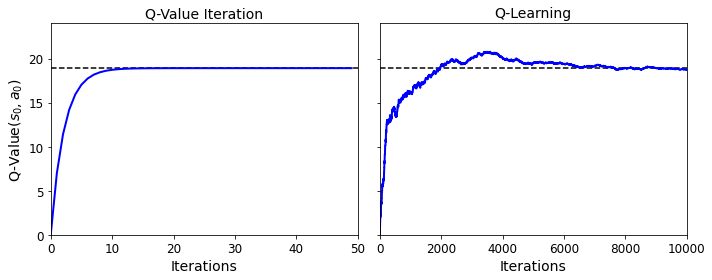

In [ ]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

save_fig("q_value_plot")

# Deep Q-Network

Recent research showed that using deep neural networks can work much better,
especially for complex problems, and it does not require any feature engineering. A DNN used to estimate Q-Values is called a Deep Q-Network (DQN), and using a DQN for Approximate Q-Learning is called Deep Q-Learning.


Let's build the DQN. Given a state, it will estimate, for each possible action, the sum of discounted future rewards it can expect after it plays that action (but before it sees its outcome). To solve the CartPole environment, we do not
need a very complicated neural net; a couple of hidden layers will do:

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

To select an action using this DQN, we just pick the action with the largest predicted Q-value. However, to ensure that the agent explores the environment, we choose a random action with probability `epsilon`.

In [ ]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

We will also need a replay memory. It will contain the agent's experiences, in the form of tuples: `(obs, action, reward, next_obs, done)`. We can use the `deque` class for that (but make sure to check out DeepMind's excellent [Reverb library](https://github.com/deepmind/reverb) for a much more robust implementation of experience replay):

In [ ]:
from collections import deque

replay_memory = deque(maxlen=2000)

And let's create a function to sample experiences from the replay memory. It will return 5 NumPy arrays: `[obs, actions, rewards, next_obs, dones]`.

In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

Now we can create a function that will use the DQN to play one step, and record its experience in the replay memory:

In [ ]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

Lastly, let's create a function that will sample some experiences from the replay memory and perform a training step:



In [ ]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

Let’s go through this code:

-- First we define some hyperparameters, and we create the optimizer and the loss function.

-- Then we create the `training_step()` function. It starts by sampling a batch of experiences, then it uses the DQN to predict the Q-Value for each possible action in each experience’s next state. Since we assume that the agent will be playing optimally, we only keep the maximum Q-Value for each next state. Next, we use Equation 18-7 to compute the target Q-Value for each experience’s state-action pair.

-- Next, we want to use the DQN to compute the Q-Value for each experienced state-action pair. However, the DQN will also output the Q-Values for the other possible actions, not just for the action that was actually chosen by the agent. So we need to mask out all the Q-Values we do not need. The `tf.one_hot()` function makes it easy to convert an array of action indices into such a mask. For example, if the first three experiences contain actions 1, 1, 0, respectively, then the mask will start with `[[0, 1], [0, 1], [1, 0],...]`. We can then multiply the DQN’s output with this mask, and this will zero out all the Q-Values we do not want. We then sum over axis 1 to get rid of all the zeros, keeping only the Q-Values of the experienced state-action pairs. This gives us the Q_values tensor, containing one predicted Q-Value for each experience in the batch.

-- Then we compute the loss: it is the mean squared error between the target and predicted Q-Values for the experienced state-action pairs.

-- Finally, we perform a Gradient Descent step to minimize the loss with regard to the model’s trainable variables.

And now, let's train the model!

In [ ]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

In [ ]:
for episode in range(400):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 399, Steps: 200, eps: 0.202

We run 400 episodes, each for a maximum of 200 steps. At each step, we first compute the `epsilon` value for the ε-greedy policy: it will go from 1 down to 0.01, linearly, in a bit under 500 episodes. Then we call the `play_one_step()` function, which will use the ε-greedy policy to pick an action, then execute it and record the experience in the replay buffer. If the episode is done, we exit the loop. Finally, if we are past the 50th episode, we call the `training_step()` function to train the model on one batch sampled from the replay buffer. The reason we play 50 episodes without training is to give the replay buffer some time to fill up (if we don’t wait enough, then there will not be enough diversity in the replay buffer). And that’s it, we just implemented the Deep Q-Learning algorithm!

Saving figure dqn_rewards_plot


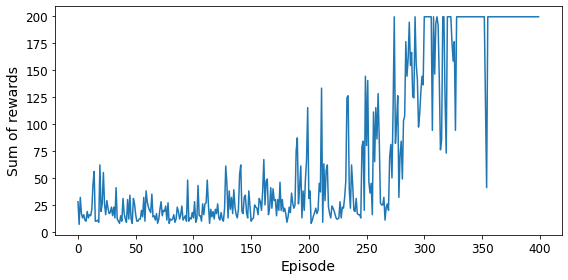

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
save_fig("dqn_rewards_plot")
plt.show()

As you can see, the algorithm made no apparent progress at all for almost 300 episodes (in part because ε was very high at the beginning), then its performance suddenly skyrocketed up to 200 (which is the maximum possible performance in this environment). That’s great news: the algorithm worked fine, and it actually ran much faster than the Policy Gradient algorithm! But wait... just a few episodes later, it forgot everything it knew, and its performance dropped below 25! This is called $\textbf{catastrophic forgetting}$, and it is one of the big problems facing virtually all RL algorithms: as the agent explores the environment, it updates its policy, but what it learns in one part of the environment may break what it learned earlier in other parts of the environment.

In [ ]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

plot_animation(frames)

Not bad at all! 😀

# Exercise Questions

1 - How would you define Reinforcement Learning? How is it different from regular supervised or unsupervised learning?


2 - Can you think of three possible applications of RL?

3 - We have used CartPole environment in this lab. You can further explore other environments in OpenAI gym environment by going to their official webpage https://gym.openai.com/.